<a href="https://colab.research.google.com/github/rishicarter/Reinforcement_Learning_Fundamentals/blob/main/MLBook_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
%pip install -q -U gym
%pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py


In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Imports

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# RL

In [ ]:
env=gym.make('CartPole-v1', render_mode='rgb_array')

In [ ]:
obs, info=env.reset(seed=42)

In [ ]:
img=env.render()
img.shape

(400, 600, 3)

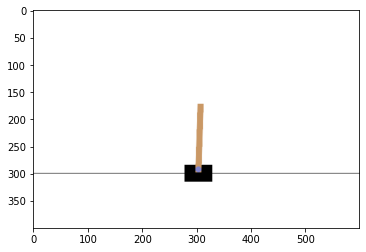

In [ ]:
plt.imshow(img)

In [ ]:
env.action_space

Discrete(2)

In [ ]:
action=1
obs,reward,done,truncated,info=env.step(action)

In [ ]:
def quick_stats():
  print(f'Obs:{obs}\nReward:{reward}\nTerminated:{done}\nTruncated:{truncated}\nInfo:{info}')

quick_stats()

Obs:[ 0.02727336  0.18847767  0.03625453 -0.26141977]
Reward:1.0
Terminated:False
Truncated:False
Info:{}


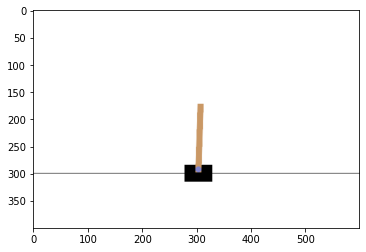

In [ ]:
plt.imshow(env.render())

In [ ]:
def basic_policy(obs):
  angle=obs[2]
  return 0 if angle < 0 else 1

totals = []
for i in range(500):
  episode_rewards=0
  obs,info=env.reset(seed=i)
  for step in range(200):
    action=basic_policy(obs)
    obs,reward,done,truncated,info=env.step(action)
    episode_rewards+=1
    if done or truncated:
      break
  totals.append(episode_rewards)
  

In [ ]:
print(f'Mean Rewards={np.mean(totals)}\nMax Reward={max(totals)}')
print(f'STD Rewards={np.std(totals)}\nMin Reward={min(totals)}')

Mean Rewards=41.698
Max Reward=63
STD Rewards=8.389445512070509
Min Reward=24


In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=332):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

# NN RL

In [ ]:
tf.random.set_seed(42)

n_inputs=4

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=[n_inputs]),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

In [ ]:
obs[np.newaxis]

array([[ 0.18901952,  0.38444525, -0.22164361, -0.5155623 ]],
      dtype=float32)

In [ ]:
tf.random.uniform([1, 1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6645621]], dtype=float32)>

In [ ]:
def play_one_step(env,obs,model,loss_fn):
  with tf.GradientTape() as tape:
    left_proba=model(obs[np.newaxis])
    action=(tf.random.uniform([1, 1])>left_proba)
    y_target=tf.constant([[1.]])-tf.cast(action, tf.float32)
    loss=tf.reduce_mean(loss_fn(y_target,left_proba))
  grads=tape.gradient(loss,model.trainable_variables)
  obs,reward,done,truncated,info=env.step(int(action))
  return obs,reward,done,truncated,grads

def play_multi_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards,all_grads=[],[]
  for episode in range(n_episodes):
    current_rewards,current_grads=[],[]
    obs, info=env.reset()
    for step in range(n_max_steps):
      obs,reward,done,truncated,grads=play_one_step(env,obs,model,loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done or truncated:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)

  return all_rewards,all_grads

def discount_rewards(rewards,discount_factor):
  discounted=np.array(rewards)
  for step in range(len(rewards)-2,-1,-1):
    discounted[step]+=discounted[step+1]*discount_factor
  return discounted

def discount_and_normalise_rewards(all_rewards, discount_factor):
  all_discounted_rewards=[discount_rewards(rewards, discount_factor) 
  for rewards in all_rewards]
  flat_rewards=np.concatenate(all_discounted_rewards)
  rewards_mean,rewards_std=flat_rewards.mean(),flat_rewards.std()
  return [(discounted_rewards-rewards_mean)/rewards_std 
          for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], discount_factor=0.8)
#array([-22, -40, -50])

array([-22, -40, -50])

In [ ]:
discount_and_normalise_rewards([[10, 0, -50], [10, 20]],discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
# Hyper-parameters

n_iterations=150
n_episodes_per_update=10
n_max_steps=200
discount_factor=0.95

optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn=tf.keras.losses.binary_crossentropy

In [ ]:
for iter in tqdm(range(n_iterations)):
  all_rewards, all_grads=play_multi_episodes(env, n_episodes_per_update, n_max_steps,
                                             model, loss_fn)
  all_final_rewards=discount_and_normalise_rewards(all_rewards,discount_factor)
  all_mean_grads=[]
  for var_index in range(len(model.trainable_variables)):
    mean_grads=tf.reduce_mean([
        final_reward*all_grads[episode_index][step][var_index]
        for episode_index, final_rewards in enumerate(all_final_rewards)
          for step,final_reward in enumerate(final_rewards)
    ],axis=0)
    all_mean_grads.append(mean_grads)
  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

100%|██████████| 150/150 [31:38<00:00, 12.66s/it]


In [ ]:
all_mean_grads

[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[-2.7859074e-03,  1.3205765e-02, -2.0657027e-02,  6.7202318e-03,
          1.8110432e-02],
        [-3.4610096e-03,  5.8285790e-03, -1.0783649e-02,  2.8287028e-03,
          8.5824654e-03],
        [ 8.8393208e-05, -5.4608210e-04,  8.6958578e-04, -2.7223237e-04,
         -4.5443303e-04],
        [ 2.2388275e-03,  5.8489986e-04, -6.5998489e-04,  4.5215822e-04,
         -2.4288100e-04]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-0.00217545, -0.00480588,  0.01216932, -0.00296337, -0.00884645],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.1524956e-05],
        [-6.4901686e-03],
        [-6.7105326e-03],
        [-1.0908536e-03],
        [-3.0632032e-04]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00730234], dtype=float32)>]

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_ten_episode(policy=None, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render())
        action = model.predict(obs[np.newaxis])
        obs, reward, done, truncated, info = env.step(int(action))
        if done or truncated:
            print(step)
            break
    env.close()
    return plot_animation(frames)

show_ten_episode()

1/1 [==============================] - 0s 24ms/step
8


# Q Learning